# Dataset size test

In [8]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
import probe_gen.probes as probes

train_dataset_names = ['science_llama_3b_5k', 'science_llama_3b_prompted_5k', 'science_qwen_3b_5k']
test_dataset_name = 'science_llama_3b_1k'

# Get train activations and labels
train_activations_tensors = []
train_labels_tensors = []
for i in range(len(train_dataset_names)):
    activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer(train_dataset_names[i], 12, verbose=True)
    activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
    train_activations_tensors.append(activations_tensor)
    train_labels_tensors.append(labels_tensor)

# Create test dataset
activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer(test_dataset_name, 12, verbose=True)
activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
_, _, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, splits=[0, 0, 1000], verbose=True)

loaded labels


llama_3b_balanced_5k_layer_12.pkl:   0%|          | 0.00/4.68G [00:00<?, ?B/s]

loaded activations with shape torch.Size([5000, 257, 3072])
calculated attention mask with shape torch.Size([5000, 257])
loaded labels


llama_3b_prompted_balanced_5k_layer_12.p(…):   0%|          | 0.00/4.75G [00:00<?, ?B/s]

loaded activations with shape torch.Size([5000, 257, 3072])
calculated attention mask with shape torch.Size([5000, 257])
loaded labels


qwen_3b_balanced_5k_layer_12.pkl:   0%|          | 0.00/4.69G [00:00<?, ?B/s]

loaded activations with shape torch.Size([5000, 253, 3072])
calculated attention mask with shape torch.Size([5000, 253])
loaded labels


llama_3b_balanced_1k_layer_12.pkl:   0%|          | 0.00/938M [00:00<?, ?B/s]

loaded activations with shape torch.Size([1000, 232, 3072])
calculated attention mask with shape torch.Size([1000, 232])
Train: 0 samples, 0.0 positives
Val:   0 samples, 0.0 positives
Test:  1000 samples, 500.0 positives


In [9]:
from probe_gen.config import ConfigDict

train_sizes = [i for i in range(500, 5000, 200)]

rocs = [[] for _ in range(len(train_dataset_names))]

for train_size in train_sizes:
    print(f"##### Training with size {train_size} #####")
    # Create train, val, and test datasets
    for i in range(len(train_dataset_names)):
        train_dataset, _, _ = probes.create_activation_datasets(train_activations_tensors[i], train_labels_tensors[i], splits=[train_size, 0, 0], verbose=False)
        probe = probes.SklearnLogisticProbe(ConfigDict(use_bias=True, C=0.01, normalize=True))
        probe.fit(train_dataset, None)
        eval_dict, _, _ = probe.eval(test_dataset)
        rocs[i].append(eval_dict['roc_auc'])
        

##### Training with size 500 #####
##### Training with size 700 #####
##### Training with size 900 #####
##### Training with size 1100 #####
##### Training with size 1300 #####
##### Training with size 1500 #####
##### Training with size 1700 #####
##### Training with size 1900 #####
##### Training with size 2100 #####
##### Training with size 2300 #####
##### Training with size 2500 #####
##### Training with size 2700 #####
##### Training with size 2900 #####
##### Training with size 3100 #####
##### Training with size 3300 #####
##### Training with size 3500 #####
##### Training with size 3700 #####
##### Training with size 3900 #####
##### Training with size 4100 #####
##### Training with size 4300 #####
##### Training with size 4500 #####
##### Training with size 4700 #####
##### Training with size 4900 #####


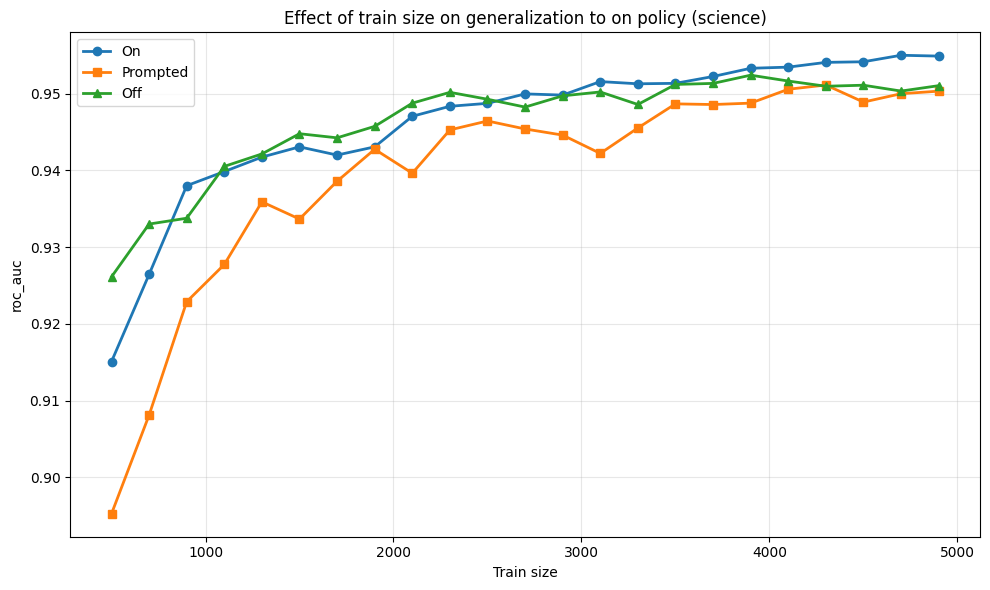

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot each line with different styles and labels
plt.plot(train_sizes, rocs[0], label='On', marker='o', linewidth=2)
plt.plot(train_sizes, rocs[1], label='Prompted', marker='s', linewidth=2)
plt.plot(train_sizes, rocs[2], label='Off', marker='^', linewidth=2)

# Customize the plot
plt.title('Effect of train size on generalization to on policy (science)')
plt.xlabel('Train size')
plt.ylabel('roc_auc')
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: set y-axis limits if needed
# plt.ylim(70, 100)

# Display the plot
plt.tight_layout()
plt.show()

# Confusion Matrices

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
import probe_gen.probes as probes
from sklearn.metrics import classification_report, confusion_matrix
from probe_gen.config import ConfigDict

activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer('sycophancy_llama_3b_4k', 12, verbose=True)
activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
# Create train, val, and test datasets
train_dataset, val_dataset, _ = probes.create_activation_datasets(activations_tensor, labels_tensor, splits=[3500, 500, 0], verbose=True)

activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer('sycophancy_arguments_llama_3b_4k', 12, verbose=True)
activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
# Create train, val, and test datasets
_, _, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, splits=[0, 0, 1000], verbose=True)

Training probe...


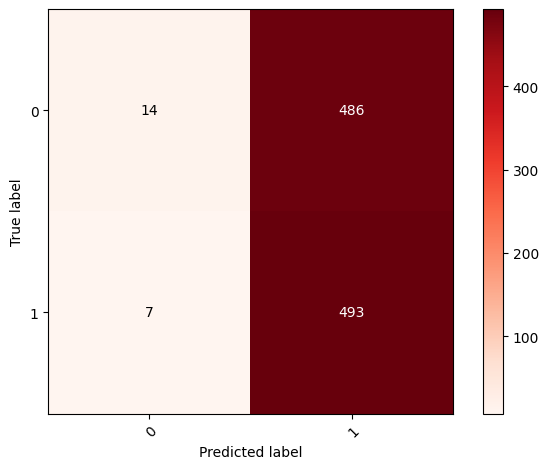

In [42]:
import matplotlib.pyplot as plt

probe = probes.SklearnLogisticProbe(ConfigDict(use_bias=True, C=0.01, normalize=True))
probe.fit(train_dataset, val_dataset)
eval_dict, y_pred, y_pred_proba = probe.eval(test_dataset)

cm = confusion_matrix(test_dataset['y'], y_pred)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap="Reds")
ax.figure.colorbar(im, ax=ax)

# Set tick marks
class_names = np.arange(cm.shape[0])
ax.set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel="True label",
    xlabel="Predicted label"
)

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text labels
fmt = "d"
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()

# Significance of small roc_aucs   

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
import probe_gen.probes as probes
from sklearn.metrics import classification_report
from probe_gen.config import ConfigDict


activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer('sycophancy_llama_3b_4k', 12, verbose=True)
activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
# Create train, val, and test datasets
train_dataset, val_dataset, _ = probes.create_activation_datasets(activations_tensor, labels_tensor, splits=[3500, 500, 0], verbose=True)

probe = probes.SklearnLogisticProbe(ConfigDict(use_bias=True, C=0.01, normalize=True))
probe.fit(train_dataset, val_dataset)

loaded labels
loaded activations with shape torch.Size([4000, 332, 3072])
calculated attention mask with shape torch.Size([4000, 332])
Train: 3500 samples, 1750.0 positives
Val:   500 samples, 250.0 positives
Test:  0 samples, 0.0 positives
Training probe...


In [4]:
activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer('sycophancy_arguments_llama_3b_4k', 12, verbose=True)
activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
# Create train, val, and test datasets
_, _, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, splits=[0, 0, 1000], verbose=True)

loaded labels
loaded activations with shape torch.Size([4000, 374, 3072])
calculated attention mask with shape torch.Size([4000, 374])
Train: 0 samples, 0.0 positives
Val:   0 samples, 0.0 positives
Test:  1000 samples, 500.0 positives


In [ ]:

def random_unit_vector(n: int) -> np.ndarray:
    v = np.random.normal(size=(1, n))   # Gaussian sample
    v /= np.linalg.norm(v)              # Normalize to unit length
    return v

rand_probe = probes.SklearnLogisticProbe(ConfigDict(use_bias=True, C=0.01, normalize=True))
rand_probe.fit(train_dataset, val_dataset)

roc_aucs = []

for i in range(1000):
    # Set random probe direction
    rand_probe.classifier.coef_ = random_unit_vector(probe.classifier.coef_.shape[1])

    # Check if cosine similarity is near orthogonal
    weights_1 = probe.classifier.coef_.flatten()
    weights_2 = rand_probe.classifier.coef_.flatten()
    if abs(cosine_similarity([weights_1], [weights_2])[0, 0]) < 0.018:
        eval_roc_auc = rand_probe.eval(test_dataset)[0]['roc_auc']
        roc_aucs.append(eval_roc_auc)

Training probe...


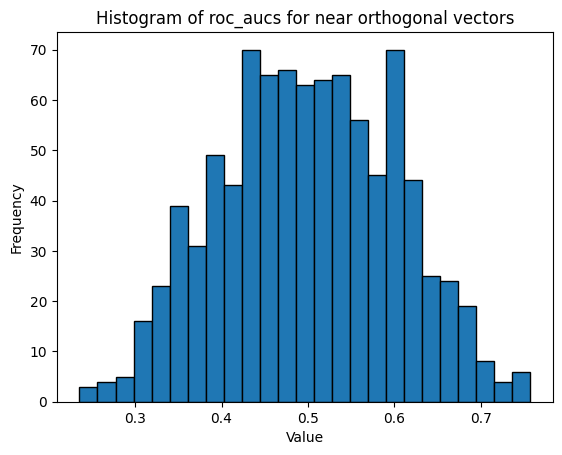

In [36]:
import matplotlib.pyplot as plt

plt.hist(roc_aucs, bins=25, edgecolor='black')  # adjust bins as needed
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of roc_aucs for near orthogonal vectors")
plt.show()